In [34]:
%reload_ext autoreload
%autoreload 2

In [35]:
import torch

from sbi.analysis import pairplot
from sbi import utils as utils
from sbi.inference import NSPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

In [36]:
num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

def simulator(theta):
    # linear gaussian
    return theta + 1.0 + torch.randn_like(theta) * 0.1

# Check prior, simulator, consistency
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator = process_simulator(simulator, prior, prior_returns_numpy)
check_sbi_inputs(simulator, prior)

In [37]:
# Create inference object. Here, NPE is used.
inference = NSPE(prior=prior, sde_type="subvp")

# generate simulations and pass to the inference object
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=2_000)
inference = inference.append_simulations(theta, x)

# train the density estimator and build the posterior
density_estimator = inference.train(stop_after_epochs=200)
posterior = inference.build_posterior(density_estimator)

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 2157 epochs.

/root/sbi/sbi/inference/posteriors/score_posterior.py:65: UserWarning: x_shape is not None. However, passing x_shape to the `Posterior` is deprecated and will be removed in a future release of `sbi`.
  super().__init__(


For an interactive, detailed view of the summary, launch tensorboard  with 'tensorboard --logdir=/root/sbi/tutorials/sbi-logs/NSPE/2024-07-10T12_44_07.302928' from a terminal on your machine, visit http://127.0.0.1:6006 afterwards. Requires port forwarding if tensorboard runs on a remote machine, as e.g. https://stackoverflow.com/a/42445070/7770835 explains.

Valid tags are: ['best_validation_loss', 'epoch_durations_sec', 'epochs_trained', 'training_loss', 'validation_loss'].


(<Figure size 2000x600 with 2 Axes>,
 array([<Axes: xlabel='epochs_trained', ylabel='training_loss'>,
        <Axes: xlabel='epochs_trained', ylabel='validation_loss'>],
       dtype=object))

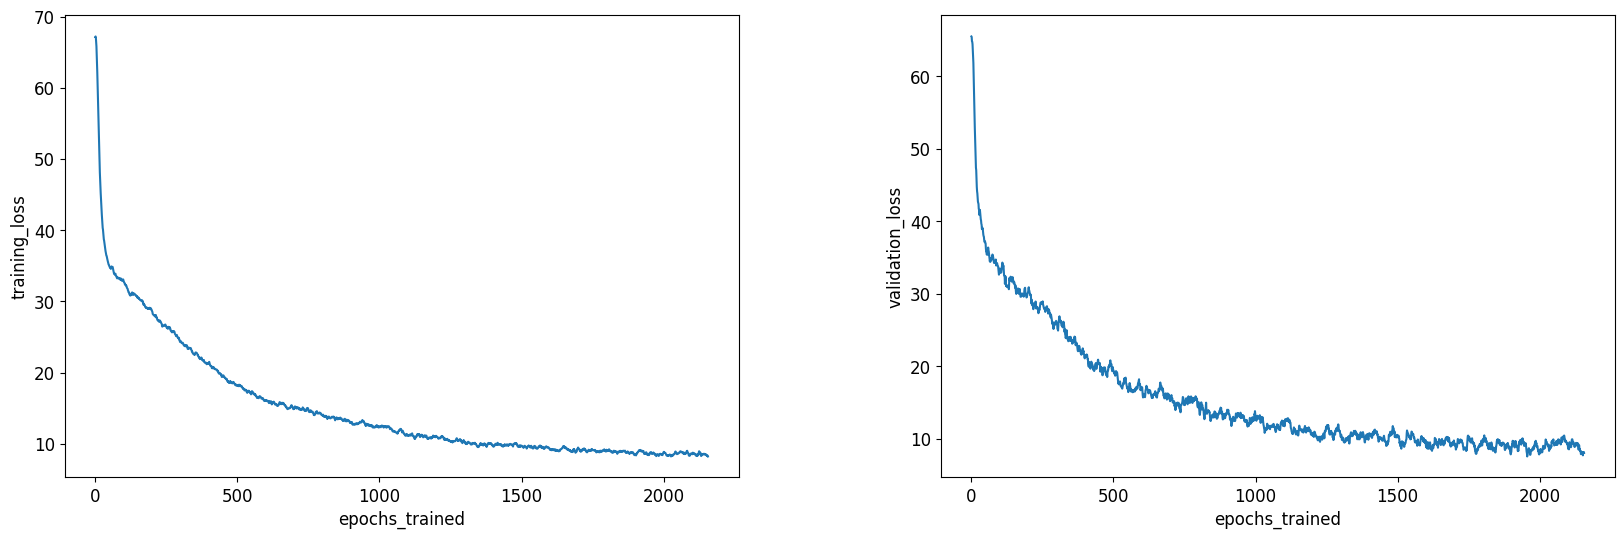

In [38]:
from sbi.analysis import plot_summary

plot_summary(inference, tags=["training_loss", "validation_loss"])

In [41]:
theta_true = prior.sample((1,))
# generate our observation
x_obs = simulator(theta_true)

Drawing 10000 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

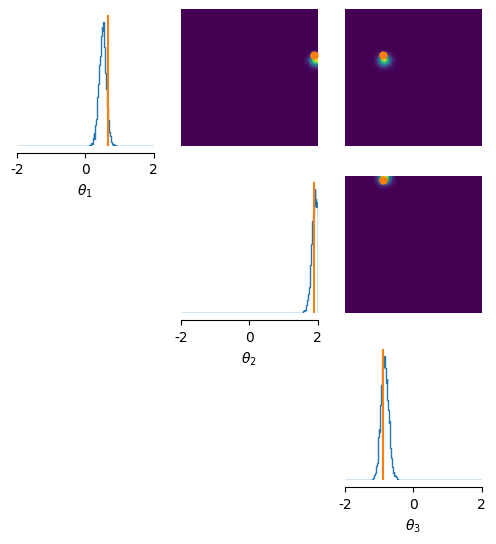

In [42]:
samples = posterior.sample((10000,), x=x_obs)
_ = pairplot(samples, points=theta_true, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(6, 6), labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"])